In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import metrics
import math
import seaborn as sns

In [2]:
################## DATA FRAME ##################
datafile = 'dailyActivity_merged.csv'
fields = ['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance', 
          'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 
          'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']

#pd.set_option('display.max_rows', 100)
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
selected_data = df[['Id','FairlyActiveMinutes', 'TotalSteps']]
n_rows, n_cols = df.shape
len(df['Id'].unique())

33

In [3]:
def reportNoisyMax(values, epsilon):
    '''
    Report differentially private noisy max - > from Section3: https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf
    '''
    rVals = list()
    for val in values:
        rval = val + np.random.laplace(0,2.0/epsilon)
        rVals.append(rval)
    
    #print(rVals)
    max_value = max(rVals)
    max_index = rVals.index(max_value)
    noisy_max = values[max_index] + np.random.laplace(0,2.0/epsilon)
    return noisy_max
        

In [4]:
values = list(selected_data['FairlyActiveMinutes'].unique())
print(values)
max(values)

[13, 19, 11, 34, 10, 20, 16, 31, 12, 8, 27, 21, 5, 14, 23, 28, 35, 15, 24, 22, 6, 46, 0, 7, 18, 36, 63, 51, 58, 4, 42, 33, 1, 41, 53, 71, 94, 17, 9, 3, 29, 26, 40, 2, 47, 25, 32, 48, 72, 43, 83, 95, 67, 98, 92, 52, 143, 96, 88, 55, 86, 116, 122, 115, 38, 39, 45, 56, 30, 66, 125, 37, 54, 74, 65, 113, 50, 69, 59, 44, 91]


143

In [5]:
privmax = reportNoisyMax(values, 1.0)
print(int(privmax))

141


In [6]:
def blockRR(value, blocks, pB):
    '''
    Perform block/interval randomized response
    with prob pB the original block is kept, (1-pB) we choose a random block
    '''
    
    valB = None
    for i in range(0, len(blocks)):
        if value in blocks[i]:
            valB = i
            break
            
    if valB is None:
        valB = len(blocks)-1
    
    #print(str(value)+" "+str(valB))
    p = random.random()
    
    if p<=pB:
        privVal = random.choice(blocks[valB])
    else:
        otherVal = list()
        for j in range(0, len(blocks)):
            if j!=valB:
                otherVal.extend(blocks[j])
                
        privVal = random.choice(otherVal)
        
    return privVal

In [36]:
#Divide the rande [0,150] into buckets of 10
n=10
blocks = list()
block = list()
for i in range(0, 151):
    block.append(i)
    if len(block)>=n:
        blocks.append(block)
        block = list()
        
print(blocks)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [70, 71, 72, 73, 74, 75, 76, 77, 78, 79], [80, 81, 82, 83, 84, 85, 86, 87, 88, 89], [90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [100, 101, 102, 103, 104, 105, 106, 107, 108, 109], [110, 111, 112, 113, 114, 115, 116, 117, 118, 119], [120, 121, 122, 123, 124, 125, 126, 127, 128, 129], [130, 131, 132, 133, 134, 135, 136, 137, 138, 139], [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]]


In [35]:
def sanitizeActProfile(IDs, individualAct, pB, blocks, memo=False):
    
    allPrivAct = dict()
    for Id in IDs:
        privAct = list()
        privmap = dict()
        
        if memo:
            for val in set(individualAct[Id]):
                pval = blockRR(val, blocks, pB)
                privmap[val] = pval

            for val in individualAct[Id]:
                privAct.append(privmap[val])
        else:
            for val in individualAct[Id]:
                pval = blockRR(val, blocks, pB)
                privAct.append(pval)
                
        allPrivAct[Id]=privAct
    return allPrivAct

In [9]:
IDs = selected_data['Id'].unique()
individualAct = dict()
selectedIDs = IDs
for Id in selectedIDs:
    act = selected_data[selected_data['Id']==Id]
    individualAct[Id] = act['FairlyActiveMinutes'].tolist()

In [10]:
#Sanitize without memoization
pB=0.85
sanProfiles = sanitizeActProfile(IDs,individualAct,pB)

In [11]:
#Sanitize with memoization
pB=0.85
sanProfilesM = sanitizeActProfile(IDs,individualAct,pB,True)

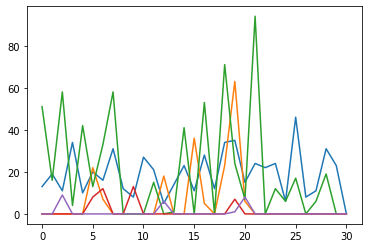

In [12]:
plotIDs = IDs[:5]
for Id in plotIDs:
    plt.plot(individualAct[Id])

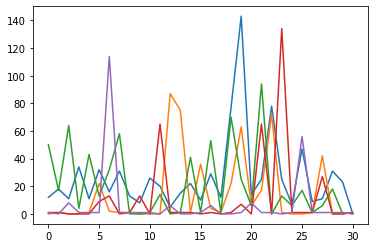

In [13]:
for Id in plotIDs:
    plt.plot(sanProfiles[Id])

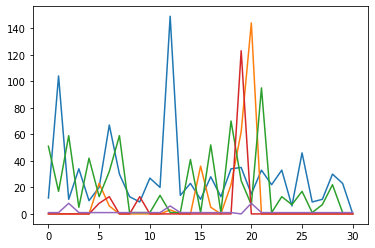

In [14]:
for Id in plotIDs:
    plt.plot(sanProfilesM[Id])

## Histogram comparison

In [15]:
orgP = list()
sanP = list()
sanPM = list()
for Id in IDs:
    orgP.extend(individualAct[Id])
    sanP.extend(sanProfiles[Id])
    sanPM.extend(sanProfilesM[Id])
    

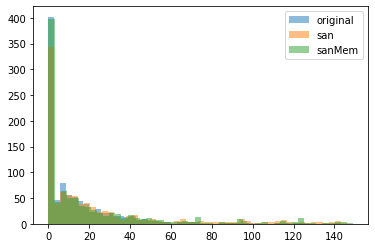

In [16]:

plt.hist(orgP, 50, alpha=0.5, label='original')
plt.hist(sanP, 50, alpha=0.5, label='san')
plt.hist(sanPM, 50, alpha=0.5, label='sanMem')
plt.legend(loc='upper right')
plt.show()

In [17]:
def getFreqRep(maxVal, values):
    freqVec = [0.0]*(maxVal+1)
    tot_val = 0.0
    for val in values:
        freqVec[val] = freqVec[val] + 1.0
        tot_val = tot_val + 1
        
    for i in range(0,len(freqVec)):
        freqVec[i] = (1.0*freqVec[i])/tot_val + 10**-6
        
    print(tot_val)
    return freqVec

In [18]:

maxValO = max(orgP)
print(maxValO)
maxValS = max(sanP)
print(maxValS)
maxVal = max(maxValO,maxValS)
print(maxVal)
orgFreqVec = getFreqRep(maxVal, orgP)
sanFreqVec = getFreqRep(maxVal, sanP)

143
146
146
940.0
940.0


In [23]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [32]:
#KL divergence
kl = KL(orgFreqVec,sanFreqVec)
print(kl)

0.4553162088354214


/var/folders/5b/vdrn5cb50gvbr2ldz7rlnvnw0000gn/T/ipykernel_61560/4152628166.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.asarray(a, dtype=np.float)
/var/folders/5b/vdrn5cb50gvbr2ldz7rlnvnw0000gn/T/ipykernel_61560/4152628166.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np.asarray(b, dtype=np.float)


In [33]:
#L1 distance
l1 = np.linalg.norm(np.asarray(orgFreqVec, dtype=np.float)-np.asarray(sanFreqVec, dtype=np.float),ord=1)
print(l1)

0.6638297872340425


/var/folders/5b/vdrn5cb50gvbr2ldz7rlnvnw0000gn/T/ipykernel_61560/3818573922.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  l1 = np.linalg.norm(np.asarray(orgFreqVec, dtype=np.float)-np.asarray(sanFreqVec, dtype=np.float),ord=1)


In [34]:
#MAX ERROR on single Entry
maxEr = max(np.asarray(orgFreqVec, dtype=np.float)-np.asarray(sanFreqVec, dtype=np.float))
print(maxEr)

0.21914893617021272


/var/folders/5b/vdrn5cb50gvbr2ldz7rlnvnw0000gn/T/ipykernel_61560/3515313611.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  maxEr = max(np.asarray(orgFreqVec, dtype=np.float)-np.asarray(sanFreqVec, dtype=np.float))


In [39]:
def initBlocks(n, maxVal):
    blocks = list()
    block = list()
    for i in range(0, maxVal):
        block.append(i)
        if len(block)>=n:
            blocks.append(block)
            block = list()
    if len(block)>0:
        blocks.append(block)
    return blocks

In [46]:
eps = [0.01, 0.1, 1.0, 5.0, 10.0]
B = [5, 10]
results = list()
for n in B:
    blocks = initBlocks(n, 150)
    for ep in eps:
        pB = math.exp(ep)/(n-1+math.exp(ep))
        sanProfiles = sanitizeActProfile(IDs,individualAct,pB,blocks)
        sanP = list()
        for Id in IDs:
            sanP.extend(sanProfiles[Id])
        maxValS = max(sanP)
        maxVal = max(maxValO,maxValS)
        sanFreqVec = getFreqRep(maxVal, sanP)
        orgFreqVec = getFreqRep(maxVal, orgP)
        maxEr = max(np.asarray(orgFreqVec, dtype=np.float)-np.asarray(sanFreqVec, dtype=np.float))
        kl = KL(orgFreqVec,sanFreqVec)
        l1 = np.linalg.norm(np.asarray(orgFreqVec, dtype=np.float)-np.asarray(sanFreqVec, dtype=np.float),ord=1)
        results.append((ep, n, maxEr, kl, l1))

df = pd.DataFrame(results, columns=['Epsilon', 'blockSize', 'maxErr', 'L1', 'KL'])



        

940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0
940.0


/var/folders/5b/vdrn5cb50gvbr2ldz7rlnvnw0000gn/T/ipykernel_61560/2495754510.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  maxEr = max(np.asarray(orgFreqVec, dtype=np.float)-np.asarray(sanFreqVec, dtype=np.float))
/var/folders/5b/vdrn5cb50gvbr2ldz7rlnvnw0000gn/T/ipykernel_61560/4152628166.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca

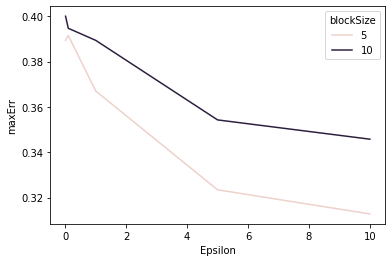

In [52]:
g = sns.lineplot(x="Epsilon", y="maxErr", hue="blockSize", data=df)

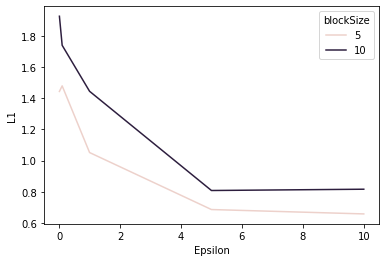

In [53]:
g = sns.lineplot(x="Epsilon", y="L1", hue="blockSize", data=df)

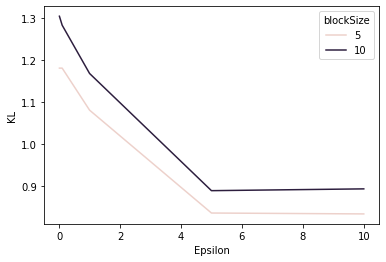

In [55]:
g = sns.lineplot(x="Epsilon", y="KL", hue="blockSize", data=df)

## Choosing Epsilon for indistinguishability at block level

How we choose pB for a single release?

Pr[M(b1)=b']/Pr[M(b2)=b'] = pB/((1-pB)/|B|-1) <= e^\epsilon
-> pB <= e^\epsilon/(|B|-1+e^\epsilon)

where |B| = number of intervals/blocks, and \epsilon privacy parameter

In [66]:
epsilon = 5.0
B = len(blocks)
pB = math.exp(epsilon)/(B-1+math.exp(epsilon))
print(pB)

0.9138000881372063


## Choosing Epsilon for indistinguishability at value level

Pr[M(v1)=v']/Pr[M(v2)=v'] = (pB/m)/((1-pB)(1/(n-m)) <= e^\epsilon
-> pB <= e^\epsilon/(e^\epsilon+n/m+1)

where n = domain, m=size of the interval

In [67]:
epsilon = 5.0
n=max(selected_data['FairlyActiveMinutes'])
m=max(len(x) for x in blocks)
pB = math.exp(epsilon)/(math.exp(epsilon)+n/m-1)
print(pB)

0.9177556107752266


# Some Ideas

## Group indistiguishability:

Provide indistinguishability across group of individuals. For example, we can create 3 groups (non-active, medium active, very active) of users based on their activites. Then, we can modify our randomized response methods to provide indistinguishability within each group. This is a relaxed version of the privacy model, but it should improve usability.

Tasks:
1. use data drive approaches to create groups of individuals
2. measure the uniqueness in each group